# TM10007 Assignment: ADNI

In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

# Import necessary functions/packages

In [2]:
# General packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from scipy import interp
from scipy.stats import randint

# Classifiers
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, RobustScaler, label_binarize
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.linear_model import Lasso, RidgeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, learning_curve, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.fixes import loguniform
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Statistics
from statistics import mean

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Some functions we will use 

In [0]:
def removezeros(X):
  '''
  Remove features with only zero's as values
  '''
  X_nozeros = X.loc[:, (X != 0).any(axis=0)]
  return X_nozeros

def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

def plot_roc_curve(y_score, y_truth):
    '''
    Plot an ROC curve.
    '''
    # Only take scores for class = 1
    y_score = y_score[:, 1]
    
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_truth, y_score)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

# Data loading and preprocessing

In [4]:
# Data loading functions
from adni.load_data import load_data 
data = load_data()
print(data.head())
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# Creating vector of labels
data_no_label = data.drop(columns='label')
print(f'The number of features: {len(data_no_label.columns)}')
x = data_no_label
y = data['label']

# Check if there are NaN's
x_nan = np.isnan(x.values)
print(f'The number of found NaN is: {np.sum(x_nan)}')

# Remove features with only zero's as values
x_df = removezeros(x)
print(f'The number of features after removing zero-features: {len(x_df.columns)}')

# Get values of of the features
x = x_df.values

# Binarize the labels
y_bin = label_binarize(y,['AD','CN'])
y_bin = [i[0] for i in y_bin]
y_bin = np.array(y_bin)

                     hf_energy  ...  vf_Frangi_inner_std_SR(1.0, 10.0)_SS2.0
ID                              ...                                         
0_002_S_0413_bl_0  5403.229408  ...                             4.207831e-10
0_002_S_0559_bl_0   922.459760  ...                             3.137258e-10
0_002_S_0619_bl_0  1674.765276  ...                             4.219847e-10
0_002_S_0685_bl_0  3443.797200  ...                             5.954654e-11
0_002_S_0816_bl_0   914.469846  ...                             4.174750e-10

[5 rows x 268 columns]
The number of samples: 855
The number of columns: 268
The number of features: 267
The number of found NaN is: 0
The number of features after removing zero-features: 263


# Feature selection with RFECV 

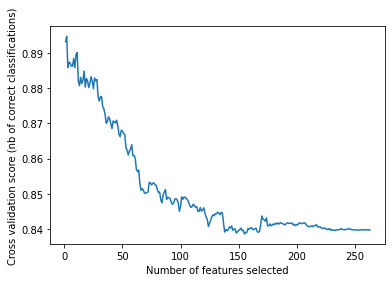

In [5]:
#For now use 1 iteration (n_splits=1) to test RFECV method
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(x, y_bin):
    
    X_train = x[train_index]
    y_train = y_bin[train_index]
    X_test = x[test_index]
    y_test = y_bin[test_index]

    # Scaling of features
    scaler = StandardScaler()   #Can be changed to RobustScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #Create the RFE object and compute a cross-validated score.
    svc = SVC(kernel="linear")
    # The \"accuracy\" scoring is proportional to the number of correct classifications
    rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
            scoring='roc_auc')
    select = rfecv.fit(X_train_scaled, y_train)
    
    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()

#Plot explained variance for choosing a number of components for PCA


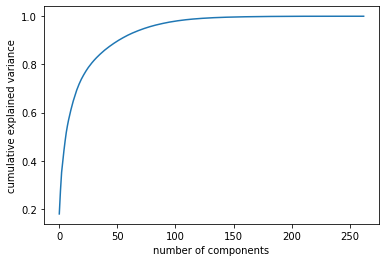

In [6]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(x, y_bin):
    
    X_train = x[train_index]
    y_train = y_bin[train_index]
    X_test = x[test_index]
    y_test = y_bin[test_index]

    # Scaling of features
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    
    # PCA
    pca = PCA().fit(X_train_scaled)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')

# SVM classifier with L1 feature selection

In [0]:
sss = StratifiedShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
train_auc_scores = []
test_auc_scores = []
train_accuracy_scores = []
test_accuracy_scores = []

for train_index, test_index in sss.split(x, y_bin):
    
    X_train = x[train_index]
    y_train = y_bin[train_index]
    X_test = x[test_index]
    y_test = y_bin[test_index]

    # Scaling of features
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Feature selection - L1 method
    selector = SelectFromModel(estimator=Lasso(alpha=10**(-10), random_state=42), threshold='median')
    selector.fit(X_train_scaled, y_train)
    n_original = X_train_scaled.shape[1]
    X_train = selector.transform(X_train_scaled)
    X_test = selector.transform(X_test_scaled)
    n_selected = X_train.shape[1]
    print(f"Selected {n_selected} from {n_original} features with L1 method.")
    
    # Define hyperparameters for SVM 
    SVM_param = {'C': loguniform(1e0, 1e3), 
                  'gamma': loguniform(1e-4, 1e0), 
                  'kernel': ['rbf','poly', 'linear']}  

    # Perform randomized search with cross-validation for hyperparameter optimization
    cv_10fold = StratifiedKFold(n_splits=5)
    grid = RandomizedSearchCV(SVC(probability=True), SVM_param, cv=cv_10fold, refit = True, verbose = 3, random_state=42) 
    grid.fit(X_train, y_train)

    print("The best classifier is: ", grid.best_estimator_)

    # Determine scores for train and test set
    score_train_auc = grid.best_estimator_.predict_proba(X_train)
    score_test_auc = grid.best_estimator_.predict_proba(X_test)
    score_train_acc = grid.best_estimator_.score(X_train,y_train)
    score_test_acc = grid.best_estimator_.score(X_test,y_test)

    # Plot ROC curve for train and test set
    plot_roc_curve(score_train_auc, y_train)
    plot_roc_curve(score_test_auc, y_test)

    score_train_auc_1 = score_train_auc[:, 1]
    score_train_auc_final = roc_auc_score(y_train,score_train_auc_1)
    score_test_auc_1 = score_test_auc[:, 1]
    score_test_auc_final = roc_auc_score(y_test,score_test_auc_1)

    train_auc_scores.append(score_train_auc_final)
    test_auc_scores.append(score_test_auc_final)
    train_accuracy_scores.append(score_train_acc)
    test_accuracy_scores.append(score_test_acc)

# Create numpy array of scores and calculate the mean and std
all_train_auc = np.array(train_auc_scores)
all_test_auc = np.array(test_auc_scores)

all_train_accuracy = np.array(train_accuracy_scores)
all_test_accuracy = np.array(test_accuracy_scores)

train_scores_auc_mean = all_train_auc.mean(axis=0)
train_scores_auc_std = all_train_auc.std(axis=0)

train_scores_accuracy_mean = all_train_accuracy.mean(axis=0)
train_scores_accuracy_std = all_train_accuracy.std(axis=0)

test_scores_auc_mean = all_test_auc.mean(axis=0)
test_scores_auc_std = all_test_auc.std(axis=0)

test_scores_accuracy_mean = all_test_accuracy.mean(axis=0)
test_scores_accuracy_std = all_test_accuracy.std(axis=0)

print(f'mean train auc-score is {train_scores_auc_mean}')
print(f'mean test auc-score is {test_scores_auc_mean}')
print(f'mean train accuracy-score is {train_scores_accuracy_mean}')
print(f'mean test accuracy-score is {test_scores_accuracy_mean}')

# SVM classifier with PCA

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] C=13.292918943162162, gamma=0.6351221010640693, kernel=linear ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=13.292918943162162, gamma=0.6351221010640693, kernel=linear, score=0.825, total=  17.7s
[CV] C=13.292918943162162, gamma=0.6351221010640693, kernel=linear ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.7s remaining:    0.0s


[CV]  C=13.292918943162162, gamma=0.6351221010640693, kernel=linear, score=0.693, total=   9.5s
[CV] C=13.292918943162162, gamma=0.6351221010640693, kernel=linear ...


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   27.2s remaining:    0.0s


[CV]  C=13.292918943162162, gamma=0.6351221010640693, kernel=linear, score=0.796, total=  13.6s
[CV] C=13.292918943162162, gamma=0.6351221010640693, kernel=linear ...
[CV]  C=13.292918943162162, gamma=0.6351221010640693, kernel=linear, score=0.759, total=  13.5s
[CV] C=13.292918943162162, gamma=0.6351221010640693, kernel=linear ...
[CV]  C=13.292918943162162, gamma=0.6351221010640693, kernel=linear, score=0.787, total=  14.2s
[CV] C=218.3096839052459, gamma=0.02440060709081752, kernel=poly .....
[CV]  C=218.3096839052459, gamma=0.02440060709081752, kernel=poly, score=0.788, total=   0.2s
[CV] C=218.3096839052459, gamma=0.02440060709081752, kernel=poly .....
[CV]  C=218.3096839052459, gamma=0.02440060709081752, kernel=poly, score=0.759, total=   0.2s
[CV] C=218.3096839052459, gamma=0.02440060709081752, kernel=poly .....
[CV]  C=218.3096839052459, gamma=0.02440060709081752, kernel=poly, score=0.788, total=   0.2s
[CV] C=218.3096839052459, gamma=0.02440060709081752, kernel=poly .....
[CV]

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  7.1min finished


The best classifier is:  SVC(C=4.335281794951563, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.0005337032762603955, kernel='rbf', max_iter=-1, probability=True,
    random_state=None, shrinking=True, tol=0.001, verbose=False)


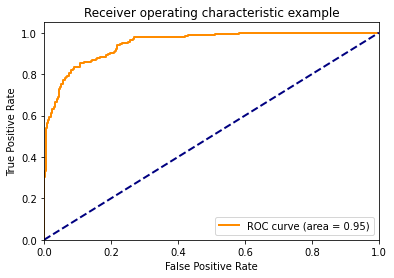

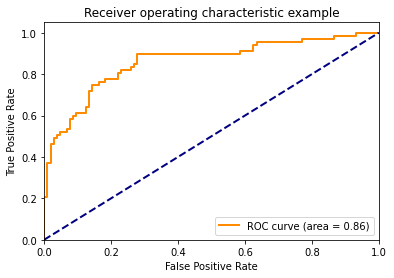

NameError: ignored

In [7]:
sss = StratifiedShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
train_auc_scores = []
test_auc_scores = []
train_accuracy_scores = []
test_accuracy_scores = []

for train_index, test_index in sss.split(x, y_bin):
    
    X_train = x[train_index]
    y_train = y_bin[train_index]
    X_test = x[test_index]
    y_test = y_bin[test_index]

    # Scaling of features
    scaler = StandardScaler()   #Can be changed to RobustScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #PCA
    pca = PCA(n_components=100)
    pca = pca.fit(X_train_scaled)
    X_train = pca.transform(X_train_scaled)
    X_test = pca.transform(X_test_scaled)
    
    # Define hyperparameters for SVM 
    SVM_param = {'C': loguniform(1e0, 1e3), 
                  'gamma': loguniform(1e-4, 1e0), 
                  'kernel': ['rbf','poly', 'linear']}  

    # Perform randomized search with cross-validation for hyperparameter optimization
    cv_10fold = StratifiedKFold(n_splits=5)
    grid = RandomizedSearchCV(SVC(probability=True), SVM_param, cv=cv_10fold, refit = True, verbose = 3, random_state=42) 
    grid.fit(X_train, y_train)

    print("The best classifier is: ", grid.best_estimator_)

    # Determine scores for train and test set
    score_train_auc = grid.best_estimator_.predict_proba(X_train)
    score_test_auc = grid.best_estimator_.predict_proba(X_test)
    score_train_acc = grid.best_estimator_.score(X_train,y_train)
    score_test_acc = grid.best_estimator_.score(X_test,y_test)

    # Plot ROC curve for train and test set
    plot_roc_curve(score_train_auc, y_train)
    plot_roc_curve(score_test_auc, y_test)

    score_train_auc_1 = score_train_auc[:, 1]
    score_train_auc_final = roc_auc_score(y_train,score_train_auc_1)
    score_test_auc_1 = score_test_auc[:, 1]
    score_test_auc_final = roc_auc_score(y_test,score_test_auc_1)

    train_auc_scores.append(score_train_auc_final)
    test_auc_scores.append(score_test_auc_final)
    train_accuracy_scores.append(score_train_acc)
    test_accuracy_scores.append(score_test_acc)

# Create numpy array of scores and calculate the mean and std
all_train_auc = np.array(train_auc_scores)
all_test_auc = np.array(test_auc_scores)

all_train_accuracy = np.array(train_accuracy_scores)
all_test_accuracy = np.array(test_accuracy_scores)

train_scores_auc_mean = all_train_auc.mean(axis=0)
train_scores_auc_std = all_train_auc.std(axis=0)

train_scores_accuracy_mean = all_train_accuracy.mean(axis=0)
train_scores_accuracy_std = all_train_accuracy.std(axis=0)

test_scores_auc_mean = all_test_auc.mean(axis=0)
test_scores_auc_std = all_test_auc.std(axis=0)

test_scores_accuracy_mean = all_test_accuracy.mean(axis=0)
test_scores_accuracy_std = all_test_accuracy.std(axis=0)

print(f'mean train auc-score is {train_scores_auc_mean}')
print(f'mean test auc-score is {test_scores_auc_mean}')
print(f'mean train accuracy-score is {train_scores_accuracy_mean}')
print(f'mean test accuracy-score is {test_scores_accuracy_mean}')

# RF with standard scaler and L1 feature selection

In [0]:
sss = StratifiedShuffleSplit(n_splits=50, test_size=0.2, random_state=0) #n_splits nog aanpassen!!
train_auc_scores = []
test_auc_scores = []
train_accuracy_scores = []
test_accuracy_scores = []

for train_index, test_index in sss.split(x, y_bin):
    
    X_train = x[train_index]
    y_train = y_bin[train_index]
    X_test = x[test_index]
    y_test = y_bin[test_index]

    # Scaling of features
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Feature selection - L1 method
    selector = SelectFromModel(estimator=Lasso(alpha=10**(-10), random_state=42), threshold='median')
    selector.fit(X_train_scaled, y_train)
    n_original = X_train_scaled.shape[1]
    X_train = selector.transform(X_train_scaled)
    X_test = selector.transform(X_test_scaled)
    n_selected = X_train.shape[1]
    print(f"Selected {n_selected} from {n_original} features with L1 method.")
    
    # Define hyperparameters for RF
    forest_parameters = {'n_estimators': list(range(50,301)), 
                      'criterion':  ['gini', 'entropy'],
                      'max_depth': [4, 5, 6, 7, 8, 9, 10],
                      'max_features': ['auto','sqrt','log2']}

    # Perform randomized search with cross-validation for hyperparameter optimization
    cv_10fold = StratifiedKFold(n_splits=5) #n_splits nog aanpassen!!
    grid = RandomizedSearchCV(RandomForestClassifier(), forest_parameters, cv=cv_10fold, refit = True, verbose = 3, random_state=42) 
    grid.fit(X_train, y_train)

    print("The best classifier is: ", grid.best_estimator_)

    # Determine scores for train and test set
    score_train_auc = grid.best_estimator_.predict_proba(X_train)
    score_test_auc = grid.best_estimator_.predict_proba(X_test)
    score_train_acc = grid.best_estimator_.score(X_train,y_train)
    score_test_acc = grid.best_estimator_.score(X_test,y_test)

    # Plot ROC curve for train and test set
    plot_roc_curve(score_train_auc, y_train)
    plot_roc_curve(score_test_auc, y_test)

    score_train_auc_1 = score_train_auc[:, 1]
    score_train_auc_final = roc_auc_score(y_train,score_train_auc_1)
    score_test_auc_1 = score_test_auc[:, 1]
    score_test_auc_final = roc_auc_score(y_test,score_test_auc_1)

    train_auc_scores.append(score_train_auc_final)
    test_auc_scores.append(score_test_auc_final)
    train_accuracy_scores.append(score_train_acc)
    test_accuracy_scores.append(score_test_acc)

# Create numpy array of scores and calculate the mean and std
all_train_auc = np.array(train_auc_scores)
all_test_auc = np.array(test_auc_scores)

all_train_accuracy = np.array(train_accuracy_scores)
all_test_accuracy = np.array(test_accuracy_scores)

train_scores_auc_mean = all_train_auc.mean(axis=0)
train_scores_auc_std = all_train_auc.std(axis=0)

train_scores_accuracy_mean = all_train_accuracy.mean(axis=0)
train_scores_accuracy_std = all_train_accuracy.std(axis=0)

test_scores_auc_mean = all_test_auc.mean(axis=0)
test_scores_auc_std = all_test_auc.std(axis=0)

test_scores_accuracy_mean = all_test_accuracy.mean(axis=0)
test_scores_accuracy_std = all_test_accuracy.std(axis=0)

print(f'mean train auc-score is {train_scores_auc_mean}')
print(f'mean test auc-score is {test_scores_auc_mean}')
print(f'mean train accuracy-score is {train_scores_accuracy_mean}')
print(f'mean test accuracy-score is {test_scores_accuracy_mean}')

# RF with robust scalar and L1 feature selection

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.056068778402537, tolerance: 0.01632090643274855
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 
[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.774, total=   1.6s
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.788, total=   1.5s
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s


[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.810, total=   1.5s
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 
[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.796, total=   1.5s
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 
[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.824, total=   1.5s
[CV] n_estimators=157, max_features=auto, max_depth=5, criterion=gini 
[CV]  n_estimators=157, max_features=auto, max_depth=5, criterion=gini, score=0.766, total=   0.5s
[CV] n_estimators=157, max_features=auto, max_depth=5, criterion=gini 
[CV]  n_estimators=157, max_features=auto, max_depth=5, criterion=gini, score=0.788, total=   0.5s
[CV] n_estimators=157, max_features=auto, max_depth=5, criterion=gini 
[CV]  n_estimators=157, max_features=auto, max_depth=5, criterion=gini, score=0.810, total=   0.5s
[CV] n_estimators=157, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   40.8s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=157,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


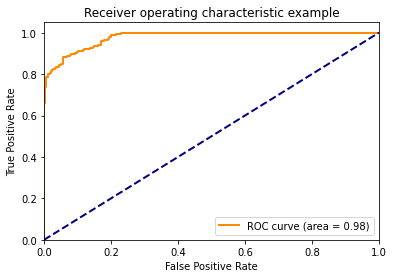

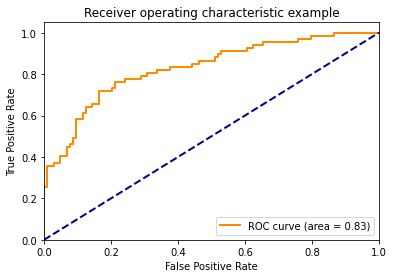

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.666367999917977, tolerance: 0.01632090643274854
  positive)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Selected 132 from 263 features with L1 method.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 
[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.788, total=   1.6s
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.825, total=   1.5s
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s


[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.818, total=   1.5s
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 
[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.810, total=   1.5s
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 
[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.757, total=   1.5s
[CV] n_estimators=157, max_features=auto, max_depth=5, criterion=gini 
[CV]  n_estimators=157, max_features=auto, max_depth=5, criterion=gini, score=0.774, total=   0.5s
[CV] n_estimators=157, max_features=auto, max_depth=5, criterion=gini 
[CV]  n_estimators=157, max_features=auto, max_depth=5, criterion=gini, score=0.818, total=   0.5s
[CV] n_estimators=157, max_features=auto, max_depth=5, criterion=gini 
[CV]  n_estimators=157, max_features=auto, max_depth=5, criterion=gini, score=0.788, total=   0.5s
[CV] n_estimators=157, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   41.2s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=6, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=292,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


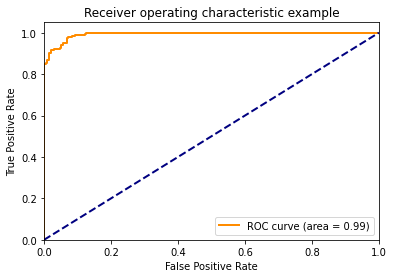

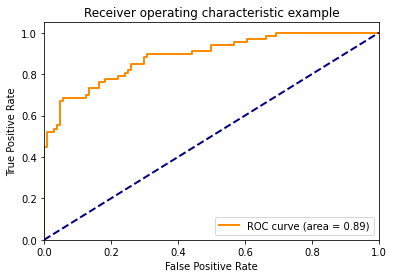

mean train auc-score is 0.9855511264388408
mean test auc-score is 0.8581371986222732
mean train accuracy-score is 0.9305555555555556
mean test accuracy-score is 0.7777777777777777


In [0]:
sss = StratifiedShuffleSplit(n_splits=50, test_size=0.2, random_state=0) #n_splits nog aanpassen!!
train_auc_scores = []
test_auc_scores = []
train_accuracy_scores = []
test_accuracy_scores = []

for train_index, test_index in sss.split(x, y_bin):
    
    X_train = x[train_index]
    y_train = y_bin[train_index]
    X_test = x[test_index]
    y_test = y_bin[test_index]

    # Scaling of features
    scaler = RobustScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Feature selection - L1 method
    selector = SelectFromModel(estimator=Lasso(alpha=10**(-10), random_state=42), threshold='median')
    selector.fit(X_train_scaled, y_train)
    n_original = X_train_scaled.shape[1]
    X_train = selector.transform(X_train_scaled)
    X_test = selector.transform(X_test_scaled)
    n_selected = X_train.shape[1]
    print(f"Selected {n_selected} from {n_original} features with L1 method.")
    
    # Define hyperparameters for RF
    forest_parameters = {'n_estimators': list(range(50,301)), 
                      'criterion':  ['gini', 'entropy'],
                      'max_depth': [4, 5, 6, 7, 8, 9, 10],
                      'max_features': ['auto','sqrt','log2']}

    # Perform randomized search with cross-validation for hyperparameter optimization
    cv_10fold = StratifiedKFold(n_splits=5) #n_splits nog aanpassen!!
    grid = RandomizedSearchCV(RandomForestClassifier(), forest_parameters, cv=cv_10fold, refit = True, verbose = 3, random_state=42) 
    grid.fit(X_train, y_train)

    print("The best classifier is: ", grid.best_estimator_)

    # Determine scores for train and test set
    score_train_auc = grid.best_estimator_.predict_proba(X_train)
    score_test_auc = grid.best_estimator_.predict_proba(X_test)
    score_train_acc = grid.best_estimator_.score(X_train,y_train)
    score_test_acc = grid.best_estimator_.score(X_test,y_test)

    # Plot ROC curve for train and test set
    plot_roc_curve(score_train_auc, y_train)
    plot_roc_curve(score_test_auc, y_test)

    score_train_auc_1 = score_train_auc[:, 1]
    score_train_auc_final = roc_auc_score(y_train,score_train_auc_1)
    score_test_auc_1 = score_test_auc[:, 1]
    score_test_auc_final = roc_auc_score(y_test,score_test_auc_1)

    train_auc_scores.append(score_train_auc_final)
    test_auc_scores.append(score_test_auc_final)
    train_accuracy_scores.append(score_train_acc)
    test_accuracy_scores.append(score_test_acc)

# Create numpy array of scores and calculate the mean and std
all_train_auc = np.array(train_auc_scores)
all_test_auc = np.array(test_auc_scores)

all_train_accuracy = np.array(train_accuracy_scores)
all_test_accuracy = np.array(test_accuracy_scores)

train_scores_auc_mean = all_train_auc.mean(axis=0)
train_scores_auc_std = all_train_auc.std(axis=0)

train_scores_accuracy_mean = all_train_accuracy.mean(axis=0)
train_scores_accuracy_std = all_train_accuracy.std(axis=0)

test_scores_auc_mean = all_test_auc.mean(axis=0)
test_scores_auc_std = all_test_auc.std(axis=0)

test_scores_accuracy_mean = all_test_accuracy.mean(axis=0)
test_scores_accuracy_std = all_test_accuracy.std(axis=0)

print(f'mean train auc-score is {train_scores_auc_mean}')
print(f'mean test auc-score is {test_scores_auc_mean}')
print(f'mean train accuracy-score is {train_scores_accuracy_mean}')
print(f'mean test accuracy-score is {test_scores_accuracy_mean}')

# RF with standard scalar and PCA

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.788, total=   1.7s
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.766, total=   1.7s
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s


[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.752, total=   1.6s
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 
[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.818, total=   1.6s
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 
[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.794, total=   1.6s
[CV] n_estimators=157, max_features=auto, max_depth=5, criterion=gini 
[CV]  n_estimators=157, max_features=auto, max_depth=5, criterion=gini, score=0.796, total=   0.5s
[CV] n_estimators=157, max_features=auto, max_depth=5, criterion=gini 
[CV]  n_estimators=157, max_features=auto, max_depth=5, criterion=gini, score=0.745, total=   0.5s
[CV] n_estimators=157, max_features=auto, max_depth=5, criterion=gini 
[CV]  n_estimators=157, max_features=auto, max_depth=5, criterion=gini, score=0.715, total=   0.5s
[CV] n_estimators=157, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   42.1s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=89,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


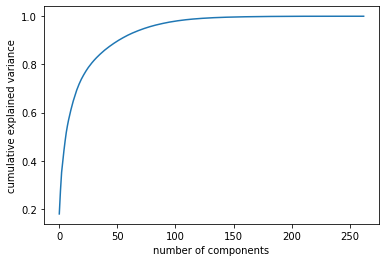

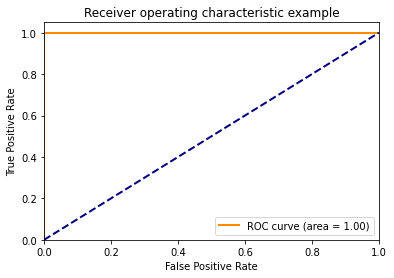

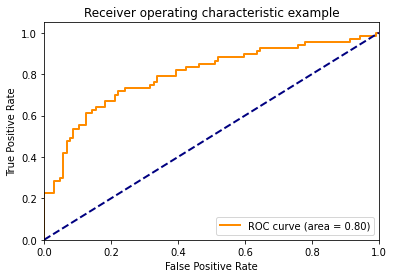

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.766, total=   1.6s
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.766, total=   1.6s
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s


[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.766, total=   1.6s
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 
[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.766, total=   1.6s
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 
[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.728, total=   1.6s
[CV] n_estimators=157, max_features=auto, max_depth=5, criterion=gini 
[CV]  n_estimators=157, max_features=auto, max_depth=5, criterion=gini, score=0.752, total=   0.5s
[CV] n_estimators=157, max_features=auto, max_depth=5, criterion=gini 
[CV]  n_estimators=157, max_features=auto, max_depth=5, criterion=gini, score=0.788, total=   0.5s
[CV] n_estimators=157, max_features=auto, max_depth=5, criterion=gini 
[CV]  n_estimators=157, max_features=auto, max_depth=5, criterion=gini, score=0.759, total=   0.5s
[CV] n_estimators=157, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   41.9s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=89,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


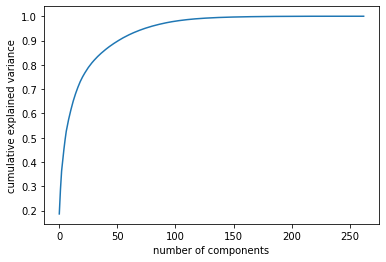

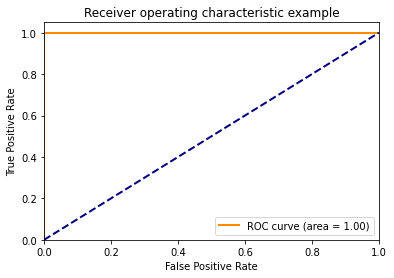

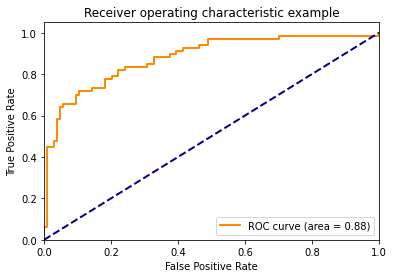

mean train auc-score is 0.999995521117929
mean test auc-score is 0.8376865671641791
mean train accuracy-score is 0.9912280701754386
mean test accuracy-score is 0.7807017543859649


In [0]:
# Repeat the experiment 20 times, use 20 random splits in which class balance is retained
sss = StratifiedShuffleSplit(n_splits=50, test_size=0.2, random_state=0) #n_splits nog aanpassen!!
train_auc_scores = []
test_auc_scores = []
train_accuracy_scores = []
test_accuracy_scores = []

for train_index, test_index in sss.split(x, y_bin):
    
    X_train = x[train_index]
    y_train = y_bin[train_index]
    X_test = x[test_index]
    y_test = y_bin[test_index]

    # Scaling of features
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #PCA
    pca = PCA(n_components=100)
    pca = pca.fit(X_train_scaled)
    X_train = pca.transform(X_train_scaled)
    X_test = pca.transform(X_test_scaled)
    
    # Define hyperparameters for RF
    forest_parameters = {'n_estimators': list(range(50,301)), 
                      'criterion':  ['gini', 'entropy'],
                      'max_depth': [4, 5, 6, 7, 8, 9, 10],
                      'max_features': ['auto','sqrt','log2']}

    # Perform randomized search with cross-validation for hyperparameter optimization
    cv_10fold = StratifiedKFold(n_splits=5) #n_splits nog aanpassen!!
    grid = RandomizedSearchCV(RandomForestClassifier(), forest_parameters, cv=cv_10fold, refit = True, verbose = 3, random_state=42) 
    grid.fit(X_train, y_train)

    print("The best classifier is: ", grid.best_estimator_)

    # Determine scores for train and test set
    score_train_auc = grid.best_estimator_.predict_proba(X_train)
    score_test_auc = grid.best_estimator_.predict_proba(X_test)
    score_train_acc = grid.best_estimator_.score(X_train,y_train)
    score_test_acc = grid.best_estimator_.score(X_test,y_test)

    # Plot ROC curve for train and test set
    plot_roc_curve(score_train_auc, y_train)
    plot_roc_curve(score_test_auc, y_test)

    score_train_auc_1 = score_train_auc[:, 1]
    score_train_auc_final = roc_auc_score(y_train,score_train_auc_1)
    score_test_auc_1 = score_test_auc[:, 1]
    score_test_auc_final = roc_auc_score(y_test,score_test_auc_1)

    train_auc_scores.append(score_train_auc_final)
    test_auc_scores.append(score_test_auc_final)
    train_accuracy_scores.append(score_train_acc)
    test_accuracy_scores.append(score_test_acc)

# Create numpy array of scores and calculate the mean and std
all_train_auc = np.array(train_auc_scores)
all_test_auc = np.array(test_auc_scores)

all_train_accuracy = np.array(train_accuracy_scores)
all_test_accuracy = np.array(test_accuracy_scores)

train_scores_auc_mean = all_train_auc.mean(axis=0)
train_scores_auc_std = all_train_auc.std(axis=0)

train_scores_accuracy_mean = all_train_accuracy.mean(axis=0)
train_scores_accuracy_std = all_train_accuracy.std(axis=0)

test_scores_auc_mean = all_test_auc.mean(axis=0)
test_scores_auc_std = all_test_auc.std(axis=0)

test_scores_accuracy_mean = all_test_accuracy.mean(axis=0)
test_scores_accuracy_std = all_test_accuracy.std(axis=0)

print(f'mean train auc-score is {train_scores_auc_mean}')
print(f'mean test auc-score is {test_scores_auc_mean}')
print(f'mean train accuracy-score is {train_scores_accuracy_mean}')
print(f'mean test accuracy-score is {test_scores_accuracy_mean}')

# RF with robust scalar and PCA 

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.737, total=   1.6s
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.766, total=   1.6s
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s


[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.766, total=   1.6s
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 
[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.796, total=   1.6s
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 
[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.779, total=   1.6s
[CV] n_estimators=157, max_features=auto, max_depth=5, criterion=gini 
[CV]  n_estimators=157, max_features=auto, max_depth=5, criterion=gini, score=0.730, total=   0.5s
[CV] n_estimators=157, max_features=auto, max_depth=5, criterion=gini 
[CV]  n_estimators=157, max_features=auto, max_depth=5, criterion=gini, score=0.766, total=   0.5s
[CV] n_estimators=157, max_features=auto, max_depth=5, criterion=gini 
[CV]  n_estimators=157, max_features=auto, max_depth=5, criterion=gini, score=0.774, total=   0.5s
[CV] n_estimators=157, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   41.6s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=265,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


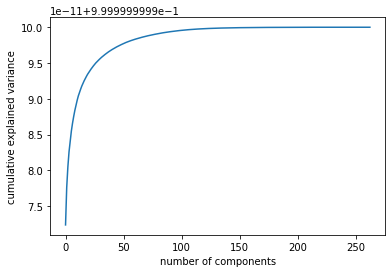

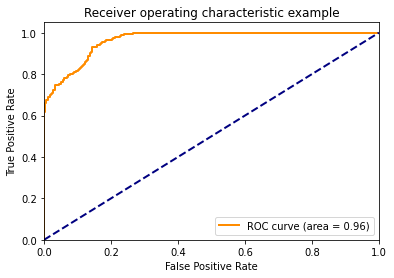

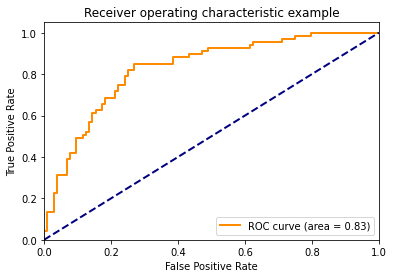

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.752, total=   1.6s
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.796, total=   1.6s
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s


[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.803, total=   1.6s
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 
[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.803, total=   1.6s
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 
[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.706, total=   1.6s
[CV] n_estimators=157, max_features=auto, max_depth=5, criterion=gini 
[CV]  n_estimators=157, max_features=auto, max_depth=5, criterion=gini, score=0.759, total=   0.5s
[CV] n_estimators=157, max_features=auto, max_depth=5, criterion=gini 
[CV]  n_estimators=157, max_features=auto, max_depth=5, criterion=gini, score=0.803, total=   0.5s
[CV] n_estimators=157, max_features=auto, max_depth=5, criterion=gini 
[CV]  n_estimators=157, max_features=auto, max_depth=5, criterion=gini, score=0.818, total=   0.5s
[CV] n_estimators=157, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   41.7s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=89,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


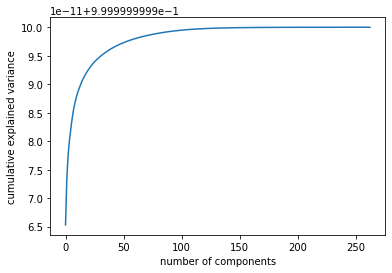

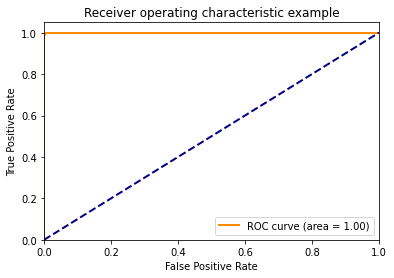

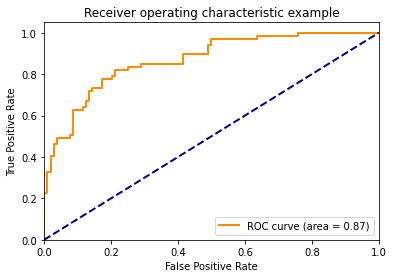

mean train auc-score is 0.9821068661262149
mean test auc-score is 0.8470866819747417
mean train accuracy-score is 0.9349415204678362
mean test accuracy-score is 0.7690058479532164


In [0]:
# Repeat the experiment 20 times, use 20 random splits in which class balance is retained
sss = StratifiedShuffleSplit(n_splits=50, test_size=0.2, random_state=0) #n_splits nog aanpassen!!
train_auc_scores = []
test_auc_scores = []
train_accuracy_scores = []
test_accuracy_scores = []

for train_index, test_index in sss.split(x, y_bin):
    
    X_train = x[train_index]
    y_train = y_bin[train_index]
    X_test = x[test_index]
    y_test = y_bin[test_index]

    # Scaling of features
    scaler = RobustScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #PCA
    pca = PCA(n_components=100)
    pca = pca.fit(X_train_scaled)
    X_train = pca.transform(X_train_scaled)
    X_test = pca.transform(X_test_scaled)
    
    # Define hyperparameters for RF
    forest_parameters = {'n_estimators': list(range(50,301)), 
                      'criterion':  ['gini', 'entropy'],
                      'max_depth': [4, 5, 6, 7, 8, 9, 10],
                      'max_features': ['auto','sqrt','log2']}

    # Perform randomized search with cross-validation for hyperparameter optimization
    cv_10fold = StratifiedKFold(n_splits=5) #n_splits nog aanpassen!!
    grid = RandomizedSearchCV(RandomForestClassifier(), forest_parameters, cv=cv_10fold, refit = True, verbose = 3, random_state=42) 
    grid.fit(X_train, y_train)

    print("The best classifier is: ", grid.best_estimator_)

    # Determine scores for train and test set
    score_train_auc = grid.best_estimator_.predict_proba(X_train)
    score_test_auc = grid.best_estimator_.predict_proba(X_test)
    score_train_acc = grid.best_estimator_.score(X_train,y_train)
    score_test_acc = grid.best_estimator_.score(X_test,y_test)

    # Plot ROC curve for train and test set
    plot_roc_curve(score_train_auc, y_train)
    plot_roc_curve(score_test_auc, y_test)

    score_train_auc_1 = score_train_auc[:, 1]
    score_train_auc_final = roc_auc_score(y_train,score_train_auc_1)
    score_test_auc_1 = score_test_auc[:, 1]
    score_test_auc_final = roc_auc_score(y_test,score_test_auc_1)

    train_auc_scores.append(score_train_auc_final)
    test_auc_scores.append(score_test_auc_final)
    train_accuracy_scores.append(score_train_acc)
    test_accuracy_scores.append(score_test_acc)

# Create numpy array of scores and calculate the mean and std
all_train_auc = np.array(train_auc_scores)
all_test_auc = np.array(test_auc_scores)

all_train_accuracy = np.array(train_accuracy_scores)
all_test_accuracy = np.array(test_accuracy_scores)

train_scores_auc_mean = all_train_auc.mean(axis=0)
train_scores_auc_std = all_train_auc.std(axis=0)

train_scores_accuracy_mean = all_train_accuracy.mean(axis=0)
train_scores_accuracy_std = all_train_accuracy.std(axis=0)

test_scores_auc_mean = all_test_auc.mean(axis=0)
test_scores_auc_std = all_test_auc.std(axis=0)

test_scores_accuracy_mean = all_test_accuracy.mean(axis=0)
test_scores_accuracy_std = all_test_accuracy.std(axis=0)

print(f'mean train auc-score is {train_scores_auc_mean}')
print(f'mean test auc-score is {test_scores_auc_mean}')
print(f'mean train accuracy-score is {train_scores_accuracy_mean}')
print(f'mean test accuracy-score is {test_scores_accuracy_mean}')

# kNN with standard scalar and L1 feature selection

In [0]:
# Repeat the experiment 20 times, use 20 random splits in which class balance is retained
sss = StratifiedShuffleSplit(n_splits=50, test_size=0.2, random_state=0) #n_splits nog aanpassen!!
train_auc_scores = []
test_auc_scores = []
train_accuracy_scores = []
test_accuracy_scores = []

for train_index, test_index in sss.split(x, y_bin):
    
    X_train = x[train_index]
    y_train = y_bin[train_index]
    X_test = x[test_index]
    y_test = y_bin[test_index]

    # Scaling of features
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Feature selection - L1 method
    selector = SelectFromModel(estimator=Lasso(alpha=10**(-10), random_state=42), threshold='median')
    selector.fit(X_train_scaled, y_train)
    n_original = X_train_scaled.shape[1]
    X_train = selector.transform(X_train_scaled)
    X_test = selector.transform(X_test_scaled)
    n_selected = X_train.shape[1]
    print(f"Selected {n_selected} from {n_original} features with L1 method.")
    
    # Define hyperparameters for kNN
    kNN_parameters = {'n_neighbors': list(range(1,101)), 
                      'weights':  ['uniform', 'distance'],
                      'metric': ['euclidean', 'manhattan']}

    # Perform randomized search with cross-validation for hyperparameter optimization
    cv_10fold = StratifiedKFold(n_splits=5) #n_splits nog aanpassen!!
    grid = RandomizedSearchCV(KNeighborsClassifier(), kNN_parameters, cv=cv_10fold, refit = True, verbose = 3, random_state=42) 
    grid.fit(X_train, y_train)

    print("The best classifier is: ", grid.best_estimator_)

    # Determine scores for train and test set
    score_train_auc = grid.best_estimator_.predict_proba(X_train)
    score_test_auc = grid.best_estimator_.predict_proba(X_test)
    score_train_acc = grid.best_estimator_.score(X_train,y_train)
    score_test_acc = grid.best_estimator_.score(X_test,y_test)

    # Plot ROC curve for train and test set
    plot_roc_curve(score_train_auc, y_train)
    plot_roc_curve(score_test_auc, y_test)

    score_train_auc_1 = score_train_auc[:, 1]
    score_train_auc_final = roc_auc_score(y_train,score_train_auc_1)
    score_test_auc_1 = score_test_auc[:, 1]
    score_test_auc_final = roc_auc_score(y_test,score_test_auc_1)

    train_auc_scores.append(score_train_auc_final)
    test_auc_scores.append(score_test_auc_final)
    train_accuracy_scores.append(score_train_acc)
    test_accuracy_scores.append(score_test_acc)

# Create numpy array of scores and calculate the mean and std
all_train_auc = np.array(train_auc_scores)
all_test_auc = np.array(test_auc_scores)

all_train_accuracy = np.array(train_accuracy_scores)
all_test_accuracy = np.array(test_accuracy_scores)

train_scores_auc_mean = all_train_auc.mean(axis=0)
train_scores_auc_std = all_train_auc.std(axis=0)

train_scores_accuracy_mean = all_train_accuracy.mean(axis=0)
train_scores_accuracy_std = all_train_accuracy.std(axis=0)

test_scores_auc_mean = all_test_auc.mean(axis=0)
test_scores_auc_std = all_test_auc.std(axis=0)

test_scores_accuracy_mean = all_test_accuracy.mean(axis=0)
test_scores_accuracy_std = all_test_accuracy.std(axis=0)

print(f'mean train auc-score is {train_scores_auc_mean}')
print(f'mean test auc-score is {test_scores_auc_mean}')
print(f'mean train accuracy-score is {train_scores_accuracy_mean}')
print(f'mean test accuracy-score is {test_scores_accuracy_mean}')

# kNN with robust scalar and L1 feature selection

# kNN with standard scalar and PCA

# kNN with robust scalar and PCA